## Imports

In [13]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import variation 
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

plt.rc('figure', figsize=(12.0, 8.0))
plt.style.use('seaborn-whitegrid')

## Business Questions

We will explore a dataset with food consumption statistics in the EU to answer the following questions:

1. Have there been any changes in Sweden consumption patterns between 1997-98 and 2010-2011?
2. What food categories are positively and negatively correlated with each other?
3. What countries have the greatest similarities in food patterns and what food items are representative of each cluster?

## Data collection and understanding

The dataset in question can be downloaded from the [efsa website](https://data.europa.eu/euodp/data/dataset/the-efsa-comprehensive-european-food-consumption-database/resource/0f73e423-b95a-408b-8e5b-a15de4fc97cf). It can also be read in directly from a url (though that increases load time). The data is available at 4 different levels of detail, with increasing granularity of each food item. For this analysis, we will only work with food items at the L1 (e.g. "Grains and grain-based products") and L2 (e.g. "Pasta") classification levels.

In [41]:
sheetname = 'L2_All_subjects_g_day'
filename = 'chronicgdaytotpop.xlsx'
    
try:
    df = pd.read_excel(filename, sheet_name=sheetname, skiprows=range(2))
except:
    df = pd.read_excel(f'http://www.efsa.europa.eu/sites/default/files/{filename}', sheet_name=sheetname, skiprows=range(2))
df = df.rename(columns={'Nr Subjetcs':'Nr Subjects'})
df.head()

,Country,Survey,Pop Class,Foodex L1,Foodex L2,Metrics,Nr Subjects,Nr Consumers,Mean,STD,P5,P10,Median,P95,P97.5,P99,Comment
0,Austria,Austrian Study on Nutritional Status 2010-12 -...,Adults,Grains and grain-based products,Grains and grain-based products,A.01.000001,308,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,
1,Austria,Austrian Study on Nutritional Status 2010-12 -...,Adults,Grains and grain-based products,Grains for human consumption,A.01.000013,308,85,15.684903,28.684094,0.0,0.0,0.0,61.0,112.0,112.0,
2,Austria,Austrian Study on Nutritional Status 2010-12 -...,Adults,Grains and grain-based products,Grain milling products,A.01.000043,308,13,2.011364,11.791651,0.0,0.0,0.0,0.0,33.0,65.5,
3,Austria,Austrian Study on Nutritional Status 2010-12 -...,Adults,Grains and grain-based products,Bread and rolls,A.01.000098,308,294,122.255519,66.426221,10.0,50.0,120.0,236.3,250.0,275.0,
4,Austria,Austrian Study on Nutritional Status 2010-12 -...,Adults,Grains and grain-based products,Pasta (Raw),A.01.000168,308,89,24.813312,45.993167,0.0,0.0,0.0,125.0,155.0,170.0,


In [42]:
# Shorten category names and save a mapping between level 1 and level 2 food items
df[['Foodex L1', 'Foodex L2']] = df[['Foodex L1', 'Foodex L2']].apply(lambda x: x.str.split('(').str[0].str.strip())
food_key = {row[1]: row[0] for i, row in df[['Foodex L1', 'Foodex L2']].drop_duplicates().iterrows()}
# Restrict analysis to adults only
df = df[df['Pop Class']=='Adults']
df = df[df['Foodex L1']!='Food for infants and small children']

Ensure each food item is measured in the same metric across surveys - each item should have only one unique code each:

In [43]:
df.pivot_table(index=[f'Foodex L2'], values='Metrics', aggfunc=['nunique', 'count']).max()

nunique  Foodex L2     1
         Metrics       1
count    Metrics      23
dtype: int64

Coming from Sweden, I'm especially interested in the consumption patterns here and how they have evolved over time. Looking at the data, we can see that one survey was performed twice, about 15 years apart. Let's see if there were any significant changes between the two: 

## Data preparation

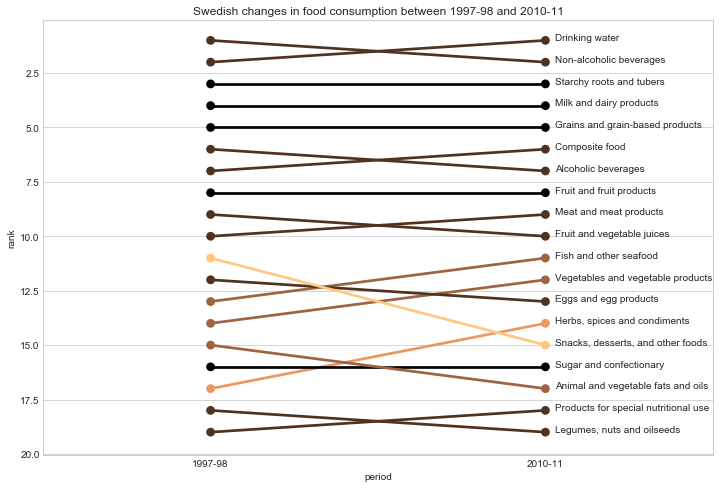

In [117]:
def group_by_year(df, food_lvl, is_rank=True):
    '''Group data by year and mean consumption of each food category'''
    df = df.pivot_table(index=food_lvl, columns='Survey', values='Mean')
    if is_rank:
        df = df.rank(ascending=False).astype(int)
        val = 'rank'
    else:
        val = 'g/day'
    df.columns = ['1997-98', '2010-11']
    df = df.sort_values(by='2010-11')
    c = df.diff(axis=1).abs().iloc[:,1].values # Use difference between surveys for color highlighting
    labels = df.index.values
    # Convert to long format for easier plotting
    df = pd.melt(df.reset_index(), id_vars=food_lvl, var_name='period', value_name=val)
    return df, labels, c

def annotate_pointplot(ax, labels, topk=100):
    '''Annotates a label to the right of the right-side column in a pointplot'''
    for i, co in enumerate(ax.collections):
        for x, y in co.get_offsets():
            if x == 1 and i >= len(ax.collections)-topk:
                label = labels[i]
                ax.annotate(label, (x*1.03, y))

def create_palette(c, style='copper'):
    'Creates a sequential palette based on the min and max value in an array'
    cmap = plt.get_cmap(style)
    norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))
    palette = cmap(norm(c))
    return palette

swe = df[df['Country']=='Sweden']
food_lvl = 'Foodex L1'

swe1, labels, c = group_by_year(swe, food_lvl, is_rank=True)
palette = create_palette(c)

fig, ax = plt.subplots()
sns.pointplot(x="period", y="rank", hue=food_lvl, data=swe1, ax=ax, palette=palette)
ax.legend('')

plt.title('Swedish changes in food consumption between 1997-98 and 2010-11')
plt.gca().invert_yaxis()
annotate_pointplot(ax, labels)

plt.savefig('images/swe_lvl1.png', bbox_inches='tight')

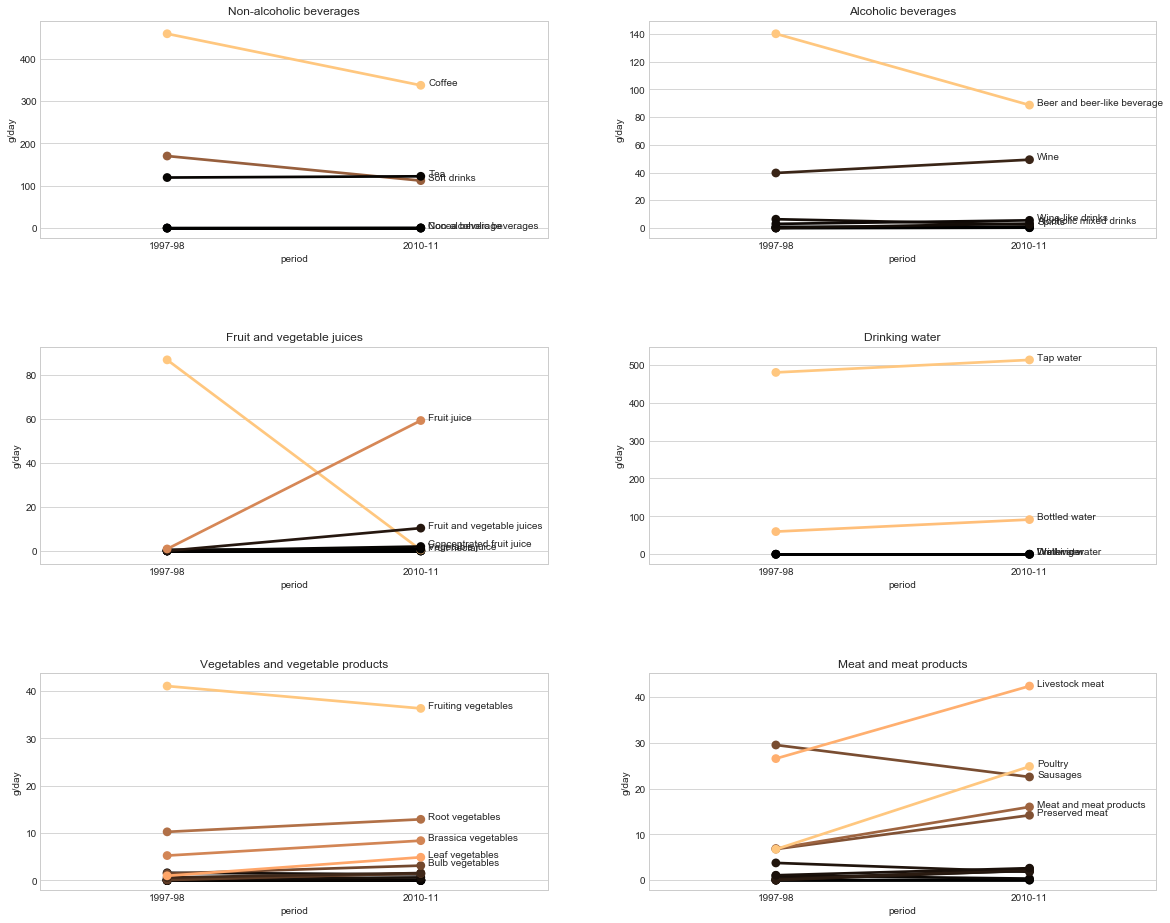

In [116]:
categories = ['Non-alcoholic beverages', 'Alcoholic beverages',
              'Fruit and vegetable juices', 'Drinking water',
              'Vegetables and vegetable products', 'Meat and meat products']

swe = df[df['Country']=='Sweden']
food_lvl = 'Foodex L2'
nrows = int(len(categories)/2)

fig, axes = plt.subplots(figsize=(20,16), nrows=nrows, ncols=2)
fig.subplots_adjust(hspace=0.5)
#fig.suptitle('Swedish changes in food consumption between 1997-98 and 2010-11')
is_rank=False
if is_rank:
    plt.gca().invert_yaxis()

for ax, category in zip(axes.flatten(), categories):
    swe1 = swe[ swe['Foodex L1']==category ]
    swe1, labels, c = group_by_year(swe1, food_lvl, is_rank=is_rank)
    palette = create_palette(c)
    sns.pointplot(x="period", y="g/day", hue=food_lvl, data=swe1, ax=ax, palette=palette)
    ax.legend('')
    annotate_pointplot(ax, labels, topk=5)  
    ax.set(title=category)
    
plt.savefig('images/swe_lvl2.png', bbox_inches='tight')

Next, let's compare the food consumption in different countries. To simplify the analysis, we'll only focus on the average consumption in each country and disregard its within-country distribution. Also, in cases where there have been several studies in the same country, we'll weigh them according to the number of respondents in each study.

In [48]:
df['Sum'] = df['Mean'] * df['Nr Subjects']
dft = df.groupby(['Country', f'Foodex L1']).sum()
dft['Mean'] = dft['Sum'] / dft['Nr Subjects']
dft = dft['Mean'].reset_index().pivot_table(index='Country', columns='Foodex L1', values='Mean')

To be able to compare variation in consumption across a number of different food items, we'll scale them so that each item has a mean of zero and standard deviation of 1.

In [49]:
index = dft.index
cols = dft.columns.str.split('(').str[0]
scaler = StandardScaler()
df_s = scaler.fit_transform(dft)
df_s = pd.DataFrame(df_s, index=index, columns=cols)

In [22]:
def remove_rare_items(df, n=10):
    '''Remove features that have less than a minimum number of records'''
    mask = (df.astype(bool).sum()>n)
    df = df[mask[mask==True].index]
    #keepcols = df.apply(variation).sort_values(ascending=False)[:30].index
    return df#[keepcols]

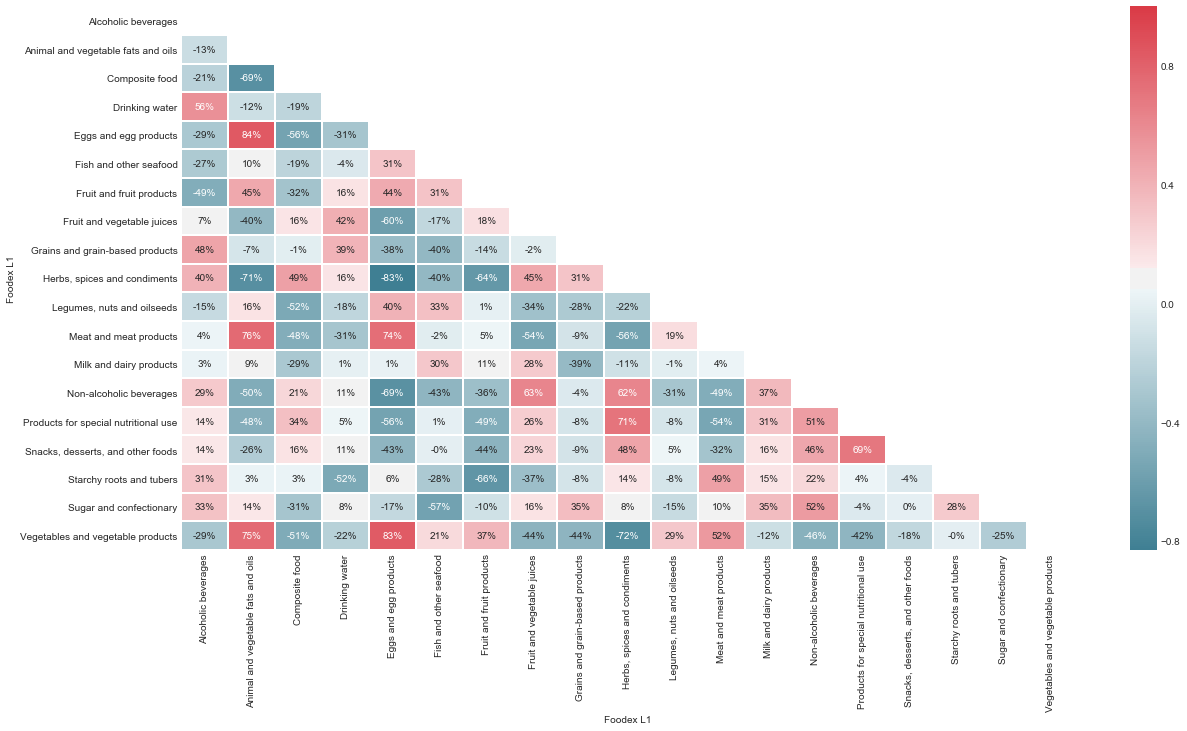

In [114]:
def plot_correlations(df):
    "Create a diagonal correlation matrix"
    mtrx = df.corr(method='pearson')
    mask = np.zeros_like(mtrx, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
       
    plt.figure(figsize=(20,10))
    sns.heatmap(mtrx, mask=mask, annot=True, fmt='0.00%', vmax=1, cmap=cmap, square=False, linewidths=1)
    return

plot_correlations(dft)
plt.savefig('images/correlation.png', bbox_inches='tight')

## Modelling

Next, we'll apply a technique called Principal Component Analysis (PCA) which lets us reduce the amount of variables. While this will make us lose some of the information in the data, it reduces complexity and makes it much easier to interpret the results.

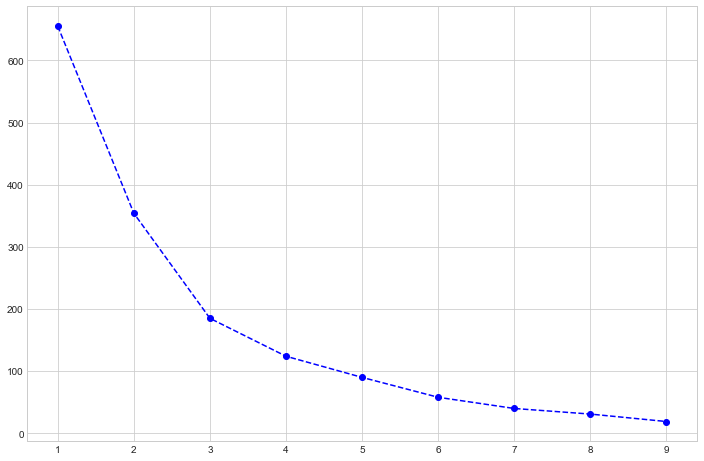

In [26]:
def fit_pca(df, n):
    '''Fit pca on a dataframe and return the resulting matrix and the pca estimator'''
    pca = PCA(n_components=n)
    X = pca.fit_transform(df_s)
    return X, pca

def fit_kmeans(X, n):
    '''Fit kmeans on a dataframe and return the predicted clusters and the kmeans estimator'''
    kmeans = KMeans(n)
    clusts = kmeans.fit_predict(X)
    return clusts, kmeans

def calculate_kmeans_scores(X):
    '''Over a number of different cluster counts, run k-means clustering on the data and compute the average within-cluster distances'''
    return {n: int(KMeans(n).fit(X).score(X)) for n in range(1,10)}

def plot_kmeans_scores(kscores):
    '''Plot within-cluster distances for different number of clusters'''
    x = kscores.keys()
    y = [np.abs(val) for val in kscores.values()]
    fig = plt.figure()
    plt.plot(x, y, linestyle='--', marker='o', color='b')
    
X, pca = fit_pca(df_s, 2)
kscores = calculate_kmeans_scores(X)
plot_kmeans_scores(kscores)

According to the graph above, the additional benefit of more than 4 clusters in marginal. Therefore, let's fit 4 different clusters of the data

In [68]:
# Reduce the number of dimensions and fit cluster centers
X, pca = fit_pca(df, 2)        
clusts, kmeans = fit_kmeans(X, n=4)
print(f'Explained variability: {pca.explained_variance_ratio_.sum():.1%}')

Explained variability: 48.8%


Now, we'll plot where each country fits in terms of the derived principal components. 

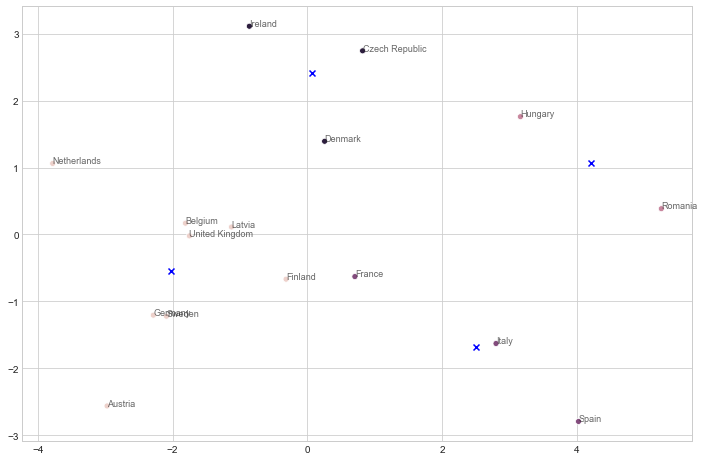

In [131]:
def annotate_scatter_plot(X, ax, text):
    for i, text in enumerate(text):
        x = X[i,0]
        y = X[i,1]
        #if text in subset:
        ax.text(x, y, text, fontsize=9, alpha=.7)    

# Plot countries along pca-axises
fig1 = plt.figure();
ax1 = plt.gca()
clusters = kmeans.predict(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], legend=False, ax=ax1, hue=clusters);
countries = df_s.index
annotate_scatter_plot(X, ax1, countries);
# Plot cluster centers
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', color='blue');
plt.savefig('images/scores2.png', bbox_inches='tight')

Interesting - we seem to have a latin, an eastern european and a germanic cluster. We also has a cluster that is less obvious, consisting of Ireland, Czech and Denmark. Let's compare these clusters to how the food items contribute to each principal component:

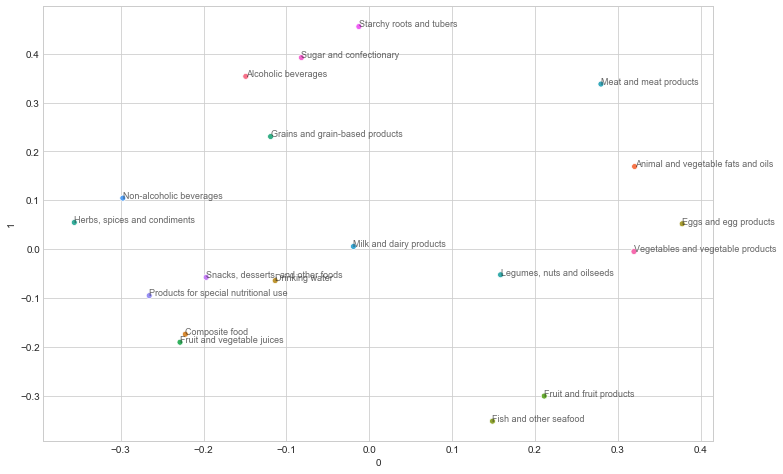

In [127]:
# Plot where each food item lies along pca axises
fig2 = plt.figure();
ax2 = plt.gca()
data=pd.DataFrame(pca.components_.T[:,:2])
data['label'] = [food_key[x] for x in df_s.columns]
sns.scatterplot(x=0, y=1, data=data, hue='label', legend=False, ax=ax2)
food_items = df_s.columns
annotate_scatter_plot(data.values, ax2, food_items)

#plt.savefig('images/loadings2.png', bbox_inches='tight')

Not surprisingly, the latin countries have a high consumption of fruit and seafood while the eastern european cluster has a high degree of fats and animal products. This also explains the not immediately obvious cluster of Ireland, Czech and Denmark - they all have high volumes of carbohydrates such as grains, sugar, beer and potatoes. 

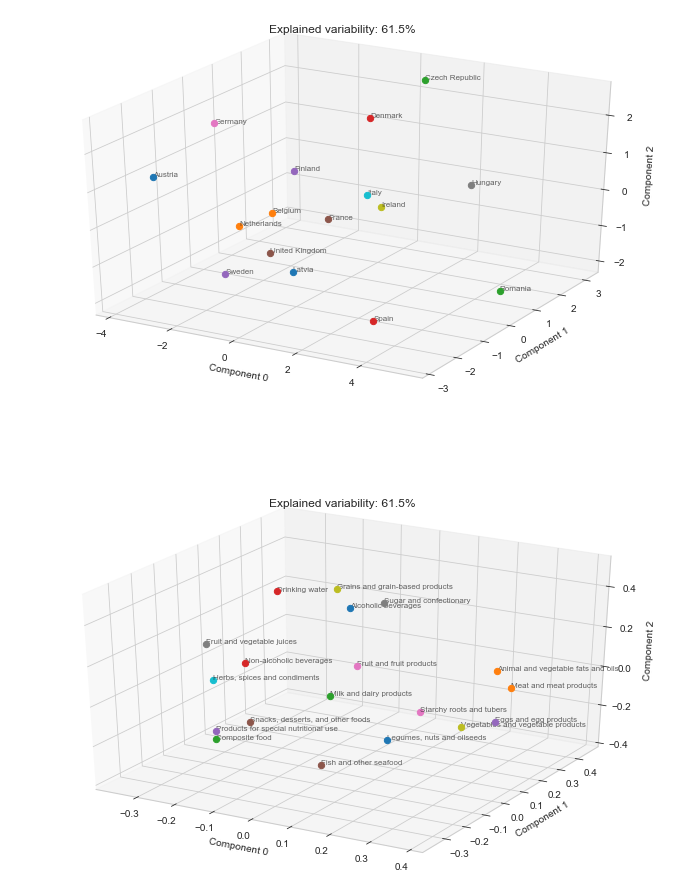

In [65]:
def plot3D(X, labels, ax):

    plt.title(f'Explained variability: {pca.explained_variance_ratio_.sum():.1%}')    
    ax.set_xlabel(f'Component 0')
    ax.set_ylabel(f'Component 1')
    ax.set_zlabel(f'Component 2')
    
    for i, c in enumerate(X):
        x = X[i,0]
        y = X[i,1]
        z = X[i,2]
        mark = 'o' #if representation[i]>0 else '^'
        ax.scatter(x, y, z, marker=mark, s=40)
        ax.text(x, y, z, labels[i], size=8, alpha=0.7)

X, pca = fit_pca(df, 3)        
clusts, kmeans = fit_kmeans(X, n=3)

fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(211, projection='3d')
countries = df_s.index
plot3D(X, countries, ax)
ax = fig.add_subplot(212, projection='3d')
food_items = df_s.columns
plot3D(pca.components_.T[:,:3], food_items, ax)

In [ ]:
subset = pd.read_excel('food_subset.xlsx')
subset = subset.loc[subset['Include']=='x', 'Foodex L2'].values
dft[subset]